In [12]:
import os
import csv
import cv2
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Dropout
from keras.layers.convolutional import Convolution2D, Cropping2D
from keras.layers.pooling import MaxPooling2D

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def read_samples(base_path):
    samples = []
    path = os.path.join(base_path, 'driving_log.csv')
    with open(path) as csvfile: 
      reader = csv.reader(csvfile)
      # Skip header line
      header = next(reader)
      for line in reader:
        samples.append(line)
    return samples

In [3]:
def get_data(base_path, samples, correction=0.25):
    images = []
    measurements = []
    for sample in samples:
        # Read steering meaturement
        
        # Read center
        path_center = os.path.join(base_path, 'IMG', sample[0].split('/')[-1])
        image_center= cv2.imread(path_center)
        steering_center = float(sample[3])
        
        # Read Left 
        path_left = os.path.join(base_path, 'IMG', sample[1].split('/')[-1])
        image_left= cv2.imread(path_left)
        steering_left = steering_center + correction
        
        # Read right
        path_right = os.path.join(base_path, 'IMG', sample[2].split('/')[-1])
        image_right= cv2.imread(path_right)
        steering_right = steering_center - correction
        
        # Append data
        images.extend([image_center, image_left, image_right])
        measurements.extend([steering_center, steering_left, steering_right])
    return images, measurements

In [4]:
def augment_data(images, measurements):
    augmented_images = []
    augmented_measurements = []
    for image, measurement in zip(images, measurements):
        augmented_images.append(image)
        augmented_measurements.append(measurement)
        flipped_image = cv2.flip(image, 1)
        flipped_measurement = float(measurement) * -1.0
        augmented_images.append(flipped_image)
        augmented_measurements.append(flipped_measurement)
    return augmented_images, augmented_measurements

In [5]:
def get_model(keep_ratio=0.25):
    model = Sequential()
    # Standardize images
    model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
    # Crop images
    model.add(Cropping2D(cropping=((70,25),(0,0)))) #crop images to isolate road lines
    
    # Convolution layer
    model.add(Convolution2D(24,5,5,subsample=(2,2),activation='relu'))
    # Convolution layer
    model.add(Convolution2D(36,5,5,subsample=(2,2),activation='relu'))
    # Convolution layer
    model.add(Convolution2D(48,5,5,subsample=(2,2),activation='relu'))
    # Convolution layer
    model.add(Convolution2D(64,3,3,activation='relu'))
    # Convolution layer
    model.add(Convolution2D(64,3,3,activation='relu'))
    
    # Flatten layers
    model.add(Flatten())
    model.add(Dense(100))
    # Fully-connected layer with Dropout to avoid over-fitting
    model.add(Dropout(keep_ratio))
    model.add(Dense(50))
    # Fully-connected layer with Dropout to avoid over-fitting
    model.add(Dropout(keep_ratio))
    model.add(Dense(20))
    # Fully-connected layer with Dropout to avoid over-fitting
    model.add(Dropout(keep_ratio))
    model.add(Dense(10))
    model.add(Dense(1))
    return model

In [ ]:
base_path = '../data'

# Read samples
samples = read_samples(base_path)[0:1000]
# Load data
X, y = get_data(base_path, samples, correction=0.25)
# Augment data
X, y = augment_data(X, y)

# Convert to numpy array
X, y = np.array(X), np.array(y)

# Split data to train ones and validation ones
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

model = get_model(keep_ratio=0.25)
model.compile(optimizer='adam', loss='mse')

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    batch_size=128,
    nb_epoch=10,
)

Train on 4800 samples, validate on 1200 samples
Epoch 1/10
4800/4800 [==============================] - 89s - loss: 0.0369 - val_loss: 0.0222
Epoch 2/10
4800/4800 [==============================] - 81s - loss: 0.0205 - val_loss: 0.0180
Epoch 3/10
4800/4800 [==============================] - 75s - loss: 0.0171 - val_loss: 0.0140
Epoch 4/10
4800/4800 [==============================] - 79s - loss: 0.0142 - val_loss: 0.0129
Epoch 5/10
4800/4800 [==============================] - 71s - loss: 0.0128 - val_loss: 0.0122
Epoch 6/10
4800/4800 [==============================] - 73s - loss: 0.0115 - val_loss: 0.0145
Epoch 7/10
4352/4800 [==========================>...] - ETA: 6s - loss: 0.0115

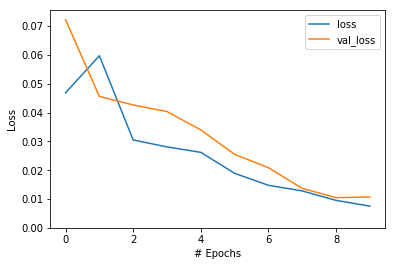

In [26]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['loss', 'val_loss'])
plt.xlabel('# Epochs')
plt.ylabel('Loss')
plt.ylim(0.0, np.max(np.array(loss.extend(val_loss))))
plt.show()

In [ ]:
save_path = 'model.hoge.h5'
model.save(save_path)